# Single Frame Condition Number Exploration

In this notebook, we explore the conditioning resulting from single-frame 1D blurs. We explore it in the context of changing the object size, blur length, and average illumination. For these fixed parameters, we optimize the illumination pattern $v\in[0,1]^p$ to maximize the minimum singular value.

This analysis extends easily to the linear multiframe setting, where identical illumination patterns are used in every frame. Recall that the forward operator is composed of shifted windows $W_j$ and blur kernels $B_j$:
$$ A = \begin{bmatrix} W_1 B_1 \\ \vdots \\ W_m B_m \end{bmatrix} =  \begin{bmatrix} W_1 \\ \vdots \\ W_m  \end{bmatrix} B \implies \kappa(A) \leq \kappa\left(\begin{bmatrix} W_1 \\ \vdots \\ W_m  \end{bmatrix}\right)\kappa(B) = \kappa(B)$$
where the statements above hold as long as (1) all $B_j$ are identical and (2) the shifted windows cover the full region of interest.

Then recall that $B$ is a Toeplitz (or circulant) matrix in the vector $b = \begin{bmatrix} v^\top & 0_{n-p} \end{bmatrix}^\top$ we use the property that
$$ \sigma(B)^2 = \sigma(B^H B) = |Fb|^2 $$

In [2]:
import numpy as np


In [3]:
F = lambda b: np.fft.fft(b)  # to do: other fourer transform library for speed?

In [4]:
# method for constructing a 1D blur matrix from an illumination pattern

def blur_matrix_1d(illum, n):
    p = len(illum)
    blur_matrix = np.zeros([n+p,n])
    for i in range(n):
        blur_matrix[i:(i+p),i] = illum
    return blur_matrix

In [5]:
# methods for generating illumination and evaluating their conditioning

def gen_rand_illum(blur_length, throughput, illum_type = 'pure_rand'):
    np.random.seed()
    if illum_type == 'pure_rand':
        illumination = np.random.rand(blur_length)
        illumination = throughput * illumination / (np.sum(illumination)) *  blur_length
    elif illum_type == 'box':
        illumination = np.zeros(blur_length)
        on_indices = np.random.choice(blur_length, int(np.ceil(throughput*blur_length)), replace=False)
        partial_on = np.random.choice(on_indices, 1, replace=False)
        illumination[on_indices] = 1
        illumination[partial_on] = 1 - ( np.ceil(throughput*blur_length) - throughput*blur_length )
    return illumination
    
def randomsearch(objective, randomgen, N_trials):
    obj_best = np.inf
    x_best = randomgen()
    for i in range(N_trials):
        x = randomgen()
        objx = objective(x)
        if objx < obj_best:
            obj_best = objx
            x_best = x
    return x_best, obj_best

def pgd(objective):
    # call pgd methods
    assert False
    
def min_sv_smooth():
    # or call kernel objectives library
    assert False
    
def illum_condition(illum, n):
    svs = get_sv(illum, n)
    min_sv = np.amin(svs)
    max_sv = np.amax(svs)
    return max_sv/min_sv, min_sv, max_sv

def illum_dnf(illum, n):
    svs = get_sv(illum, n)
    return sum(1/svs) # todo: check this!
    
def get_sv(illum, n):
    b = np.hstack([illum, np.zeros(n-illum.size)])
    return np.abs(F(b))**2

def get_blur_map(n,p):
    blur_map = np.zeros([n,p])
    for i in range(p):
        ei = np.zeros(n); ei[i] = 1
        blur_map[:,i] = F(ei)
    return blur_map


In [6]:
# method to generate an optimized illumination pattern (todo: adding PGD)
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel 
from libwallerlab.opticsalgorithms.motiondeblur import kernel_objectives 
from libwallerlab.opticsalgorithms.motiondeblur import project_simplex_box 
from libwallerlab.opticsalgorithms.motiondeblur import optimize_pgd 

def gen_illum(n, p, throughput, gentype='randomsearch', maxiter=200, x0=None):
    if gentype == 'randomsearch':
        randomgen = lambda : gen_rand_illum(p, throughput, illum_type = 'box')
        objective = lambda x: illum_condition(x, n)[0]
        illum, cond = randomsearch(objective, randomgen, maxiter)
    elif gentype == 'pgd':
        def blurMapCol(i):
            ei = np.zeros(n); ei[i] = 1
            return F(ei)
        obj = kernel_objectives.kernel_objectives(blurMapCol, 1, kernelMap=get_blur_map(n,p))
        def projis(v):
            return project_simplex_box.project(v, throughput * p, alg='is')
        f = obj.minSvSquaredSmooth
        grad = obj.gradMinSvSquared
        if x0 is None:
            x0 = gen_rand_illum(p, throughput, illum_type = 'box')
        xstar, it = optimize_pgd.projectedIterativeMax(x0, obj, f, grad, projis, \
                                                       optimize_pgd.backtrackingstep, \
                                                       optimize_pgd.smoothing_pow, maxiter, threshold=0.0005, \
                                                       verbose=False)
        illum = xstar
        cond, _, _ = illum_condition(illum, n)
    return illum, cond

/Users/zfphil/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [7]:
# confirming condition number computation
n = 1000; p = 40; throughput = 0.3
illum, _ = gen_illum(n, p, throughput, gentype='pgd', maxiter=200)
print(illum_condition(illum, n))

blur_matrix = blur_matrix_1d(illum, n)
u, s, v = np.linalg.svd(blur_matrix)
print(np.amax(s)**2 / np.amin(s)**2, np.amin(s)**2, np.amax(s)**2)


/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


(260.25531306362245, 0.5533022529852993, 143.9998510694967)
256.60365894169286 0.5603943302693536 143.7992355972956


## PGD implementation comparison

It seems that PGD is only better than a random search approach for large blur lengths. This makes sense, since larger blur lengths have many more possible configurations, and thus random search is less likely to happen upon a good one. 

However, I haven't rigorously tests wall-clock time, and I suspect that by allowing random search to run for many more iterations, the two methods may be more comparable.

In [18]:

n = 1000; p = 500; throughput = 0.1

illum, _ = gen_illum(n, p, throughput, gentype='pgd', maxiter=1000)
print('pgd', illum_condition(illum, n))

illum, _ = gen_illum(n, p, throughput, gentype='randomsearch', maxiter=1000)
print('random search', illum_condition(illum, n))

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


pgd (954.35801052402167, 2.6195669414338796, 2500.0046946613338)
random search (4674.2168307528382, 0.53484895770172158, 2500.0)


In [19]:
illum, _ = gen_illum(n, p, throughput, gentype='randomsearch', maxiter=10000)
print('random search', illum_condition(illum, n))

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


random search (3362.9456656540779, 0.74339589412122165, 2500.0)


In [20]:
# PGD on random search result

illum0, _ = gen_illum(n, p, throughput, gentype='randomsearch', maxiter=1000)
print('random search', illum_condition(illum0, n))

illum, _ = gen_illum(n, p, throughput, gentype='pgd', maxiter=1000, x0=illum0)
print('pgd', illum_condition(illum, n))



/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


random search (3515.5282755657818, 0.71113067625594772, 2500.0)


/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


pgd (838.08993768038545, 2.982973408537597, 2499.9999980635216)


## Optimized conditioning for various blur length and throughput

In [8]:
# parameters  
n = 100
p_range = np.arange(1,int(n/2))
throughput_range = np.arange(0.1,1, 0.05)

In [9]:
from joblib import Parallel, delayed
import multiprocessing
import itertools

inputs = list(itertools.product(p_range, throughput_range))

def processInput(params):
    illum, _ = gen_illum(n, params[0], params[1], gentype='randomsearch', maxiter=500)
    illum, cond = gen_illum(n, params[0], params[1], gentype='pgd', maxiter=100, x0=illum)
    return cond # return illum as well?

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)


/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [24]:
# method to replace overflow numbers with 'nan' for plotting

def replace_too_large(array):
    idx = np.where(array>1e10)
    array[idx] = np.nan
    return array

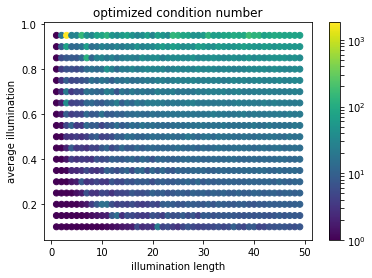

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr

params = np.array(inputs)

plt.figure(); plt.scatter(params[:,0], params[:,1], c=np.sqrt(replace_too_large(np.array(results))), norm=clr.LogNorm()); plt.colorbar()
plt.ylabel('average illumination'); plt.xlabel('illumination length'); plt.title('optimized condition number')

plt.show()

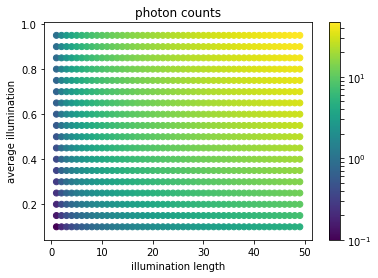

In [26]:
def photon_counts(illum_lengths, throughputs):
    # to do: include scaling between total illumination and photo counts
    # possible to do: include logic about saturation
    return illum_lengths * throughputs

plt.figure(); plt.scatter(params[:,0], params[:,1], c=photon_counts(params[:,0], params[:,1]), norm=clr.LogNorm()); plt.colorbar()
plt.ylabel('average illumination'); plt.xlabel('illumination length'); plt.title('photon counts')

plt.show()

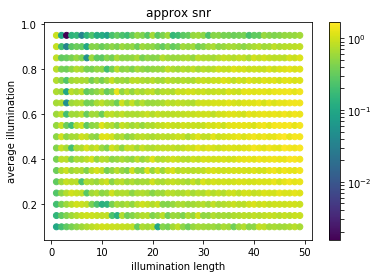

In [29]:
def SNR_bound(illum_lengths, throughputs, conditioning):
    # to do: actual relation for SNR
    return  photon_counts(illum_lengths, throughputs) / (conditioning)

approx_SNR = SNR_bound(params[:,0], params[:,1], np.sqrt(replace_too_large(np.array(results))) )

plt.figure(); plt.scatter(params[:,0], params[:,1], c=approx_SNR, norm=clr.LogNorm()); plt.colorbar()
plt.ylabel('average illumination'); plt.xlabel('illumination length'); plt.title('approx snr')

plt.show()

In [ ]:
# I think the dark stripe of blur is a weird error
# for example, with p=4 and throughput=0.5, I always get an extremely large conditioning
# (replaced with nan for plotting)

# maybe in these cases the optimal solution isn't 0-1, but has more intermediate values 
# (the current random search only searches of 0-1)